In [35]:
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import os
from datetime import datetime

DATA_DIR_AUTO = "data/final/transcripts/auto"
DATA_DIR_MANUAL = "data/final/transcripts/manual"
DATA_DIR_BEFORE_REVIEW = "data/final/transcripts/before_review"
PREFERENCE_ORDER = ['whisper', 'mixed', 'scratch']

annotation2annot_duration = {}
annotation2duration = {}

def parse_xml_file(xml_file_path):

    tree = ET.parse(xml_file_path)

    root = tree.getroot()
    recording = None
    for r in root.iter('media'):
        recording = r.attrib['url']
        break
    assert recording is not None

    root = tree.getroot()
    annot_duration = -1
    for r in root.iter('annotDuration'):
        annot_duration =  r.text
        annot_duration = datetime.strptime(annot_duration, '%H:%M:%S').time()
        annot_duration = annot_duration.hour * 3600 + annot_duration.minute * 60
        break

    #TODO: this is a foo value
    duration = 0

    utterances = []
    last_end = -1
    for u in root.iter('u'):
        # if u.text is not None and len(u.text) > 0:
        if last_end > float(u.attrib['start']):
            pass
            print(f"Overlapping utterances in {xml_file_path}")
        last_end = float(u.attrib['end'])
        utterances.append({
            'start': float(u.attrib['start']),
            'end': float(u.attrib['end']),
            'text': u.text,
            'speaker': u.attrib['who'].lower(),
            'source': u.attrib['source'] if 'source' in u.attrib else None
        })
        duration += float(u.attrib['end']) - float(u.attrib['start'])
    annotation2duration[os.path.basename(xml_file_path)] = max(annotation2duration.get(recording, 0), duration)
    annotation2annot_duration[os.path.basename(xml_file_path)] = max(annotation2annot_duration.get(recording, 0), annot_duration)
    print(xml_file_path, duration, annot_duration, len(utterances))
    return recording, utterances


def transcript_version_select(transcripts):
    for p in PREFERENCE_ORDER:
        for n, t in transcripts.items():
            if p in n:
                return t
    return next(iter(transcripts.values()))

def load_transcripts(data_dir):
    recordings = {}

    for xmlfile in os.listdir(data_dir):
        if xmlfile.endswith('.xml'):
            recording, utterances = parse_xml_file(os.path.join(data_dir, xmlfile))
            annotations = recordings.get(recording, {})
            annotations[xmlfile] = utterances
            recordings[recording] = annotations
    return recordings, {annot_name: annot for _, annotations in recordings.items() for annot_name, annot in annotations.items()}

manual_recordings, manual_annotations = load_transcripts(DATA_DIR_MANUAL)
auto_recordings, auto_annotations = load_transcripts(DATA_DIR_AUTO)
before_review_recordings, before_review_annotations = load_transcripts(DATA_DIR_BEFORE_REVIEW)

Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterances in data/final/transcripts/manual/A2ML_221205_09-ET-from_mixed.xml
Overlapping utterance

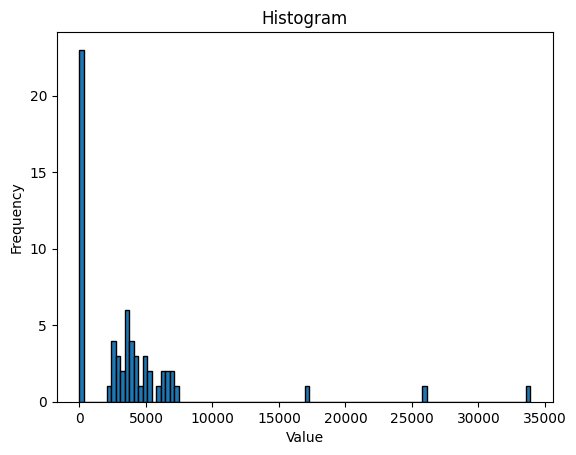

A2ML_221205_17-AP-from_mixed.xml 25920
A2ML_221205_06-LR-from_mixed.xml 33900
A2ML_230724_26-AP-from_whisperX.xml 17100
A2ML_221205_18-AP-from_scratch.xml 12960


In [4]:
import matplotlib.pyplot as plt

relevant = [
    annotation2annot_duration[annot] for annot in manual_annotations.keys()
]

# Plotting the histogram
plt.hist(relevant, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()

# print annotations with duration more than 10000 minutes
for annot, duration in annotation2annot_duration.items():
    if duration > 10000:
        print(annot, duration)

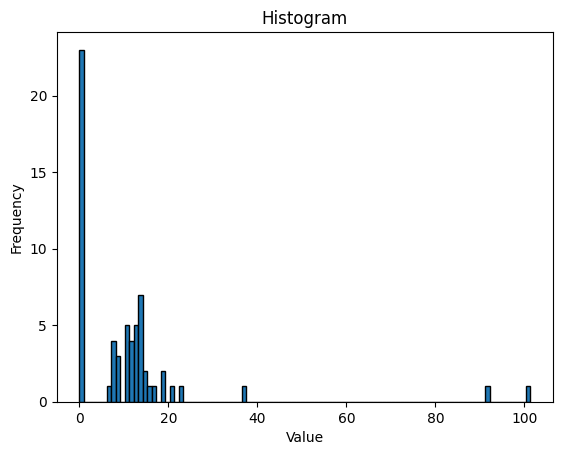

A2ML_221205_06-LR-from_mixed.xml -1
A2ML_221205_17-AP-from_mixed.xml -1
A2ML_230724_26-AP-from_whisperX.xml -1


In [51]:
import matplotlib.pyplot as plt

relevant = [
    annotation2annot_duration[annot] / annotation2duration[annot] for annot in manual_annotations.keys()
]

# Plotting the histogram
plt.hist(relevant, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()

# print annotations with duration more than 10000 minutes
for annot in manual_annotations.keys():
    if annotation2annot_duration[annot] / annotation2duration[annot] > 30:
        print(annot, duration)

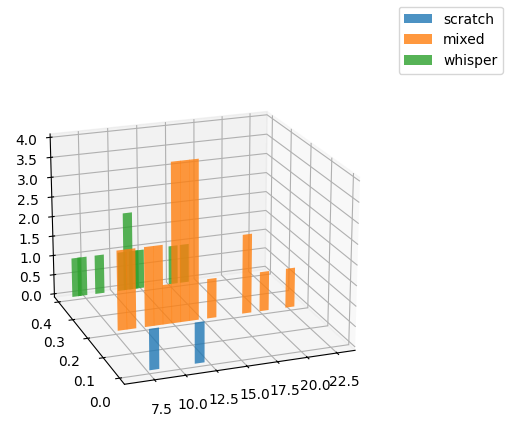

In [144]:
data = []
for t in PREFERENCE_ORDER:
    relevant = [
        annotation2annot_duration[annot] / annotation2duration[annot] for annot in before_review_annotations.keys() if t in annot and 10000 > annotation2annot_duration[annot] > 0
    ]
    data.append(relevant)

# plot three histograms in 3D plot
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=250)
for i, d in enumerate(reversed(data)):
    hist, bins = np.histogram(d, bins=20)
    xs = (bins[:-1] + bins[1:]) / 2
    ax.bar(xs, hist, zs=i/5, zdir='y', alpha=0.8)

fig.legend(list(reversed(PREFERENCE_ORDER)))


In [110]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

THRESHOLD_OVERLAP = 0.5

def get_time_overlap(utt1, utt2):
    start1, end1 = utt1['start'], utt1['end']
    start2, end2 = utt2['start'], utt2['end']
    overlap = max(0, min(end1, end2) - max(start1, start2) - THRESHOLD_OVERLAP)
    return overlap

def find_alignment(m):
    nonzeros = np.nonzero(m)
    nonzero_count_cols = np.count_nonzero(m, axis=0)
    nonzero_count_rows = np.count_nonzero(m, axis=1)
    singletons = []
    for i, j in zip(nonzeros[0], nonzeros[1]):
        singleton_row, singleton_col = False, False
        if nonzero_count_cols[j] == 1:
            singleton_col = True
        if nonzero_count_rows[i] == 1:
            singleton_row = True
        if singleton_col or singleton_row:
            singletons.append((i, j, singleton_row, singleton_col))
    print(singletons)
    alignment = []
    for idx, singleton_tuple in enumerate(singletons):
        i, j, is_row, is_col = singleton_tuple
        if idx > 0:
            prev_i, prev_j, prev_is_row, prev_is_col = singletons[idx - 1]
            if prev_is_col:
                prev_j += 1
            if prev_is_row:
                prev_i += 1
            new_i, new_j = i, j
            if is_col:
                new_j -= 1
            if is_row:
                new_i -= 1
            submatrix = m[prev_i:new_i+1, prev_j:new_j+1]
            if submatrix.size > 1:
                print(f"m[{prev_i}:{new_i}+1, {prev_j}:{new_j}+1] = {submatrix}")
                submatrix_rows, submatrix_cols = linear_sum_assignment(submatrix, maximize=True)
                for submatrix_row, submatrix_col in zip(submatrix_rows, submatrix_cols):
                    if submatrix[submatrix_row, submatrix_col] == 0:
                        continue
                    print(f"{prev_i = } {submatrix_row = } {prev_j = } {submatrix_col = }")
                    alignment.append((prev_i + submatrix_row, prev_j + submatrix_col))
        print(f"{i = }, {j = }")
        alignment.append((i, j))
    return alignment

def alignmnents_to_matrix(alignments):
    x_len = max([a[0] for a in alignments]) + 1
    y_len = max([a[1] for a in alignments]) + 1
    m = np.zeros((x_len, y_len))
    for i, j in alignments:
        m[i, j] = 1
    return m

def print_overlap_matrix(overlap_matrix):
    for i in range(overlap_matrix.shape[0]):
        print(i, end=' ')
        for j in range(overlap_matrix.shape[1]):
            print(f"{overlap_matrix[i, j]:.1f}" if overlap_matrix[i, j] else f"   ", end=' ')
        print()

def print_alignment(alignment, before_review_annotation, auto_annotation):
    for i, j in alignment:
        print("\t".join([str(i), str(j), f"{overlap_matrix[i, j]:.2f}", before_review_annotation[i]['text'], auto_annotation[j]['text']]))

def group_alignment(alignment):
    ltr_alignment_dict = defaultdict(list)
    rtl_alignment_dict = defaultdict(list)
    for i, j in alignment:
        ltr_alignment_dict[i].append(j)
        rtl_alignment_dict[j].append(i)
    grouped_alignment = []
    for i, j_list in ltr_alignment_dict.items():
        i_list = [i]
        if len(j_list) == 1:
            i_list = rtl_alignment_dict[j_list[0]]
        align = (tuple(i_list), tuple(j_list))
        if align not in grouped_alignment:
            grouped_alignment.append(align)
    return grouped_alignment

def extract_text(l, annotation):
    return " ".join([annotation[i]['text'] for i in l])

def extract_speaker(l, annotation):
    value_list = [annotation[i]['speaker'] for i in l]
    return max(set(value_list), key = value_list.count)

def extract_aligned_feat(alignments, before_review_annotation, auto_annotation, feat_f):
    feats = []
    for i, j in alignments:
        feats.append((feat_f(i, before_review_annotation), feat_f(j, auto_annotation)))
    return feats

def sample_alignment():
    key = list(before_review_annotations.keys())[0]
    print(key)
    before_review_annotation = before_review_annotations[key]
    auto_annotation = auto_annotations[key]
    print(len(before_review_annotation))
    print(len(auto_annotation))

    overlap_matrix = np.zeros((len(before_review_annotation), len(auto_annotation)))
    for i, u1 in enumerate(before_review_annotation):
        for j, u2 in enumerate(auto_annotation):
            overlap_matrix[i, j] = get_time_overlap(u1, u2)

    print_overlap_matrix(overlap_matrix)

    alignments = find_alignment(overlap_matrix)

    print_overlap_matrix(alignmnents_to_matrix(alignments))

    print(group_alignment(alignments))

    print_alignment(alignments, before_review_annotation, auto_annotation)

sample_alignment()

A2ML_221205_09-ET-from_mixed.xml
65
72
0 1.6                                                                                                                                                                                                                                                                                             
1     3.9                                                                                                                                                                                                                                                                                         
2         2.7                                                                                                                                                                                                                                                                                     
3         4.5                                                                           

In [53]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from mosestokenizer import MosesTokenizer, MosesPunctuationNormalizer
import re

PUNCT_REPLACE = re.compile(r'[\.,\?!:]+')

if not os.path.exists('alignments'):
    os.makedirs('alignments')

punct_normalizer = MosesPunctuationNormalizer('cs')
tokenizer = MosesTokenizer('cs')

excluded = set()

IS_CHAR_LEVEL = False

def normalize_text(text):
    text = text.replace('\n', ' ')
    text = punct_normalizer(text)
    text = text.replace('-', '')
    text = text.replace('*', '')
    text = text.replace('\'', '')
    text = re.sub(PUNCT_REPLACE, ' ', text)
    text = text.split()
    if IS_CHAR_LEVEL:
        return [t for t in ''.join(text).lower() if t.isalnum()]
    return [t.lower() for t in text if t.isalnum()]

def align_texts(text1, text2):
    text1 = normalize_text(text1)
    text2 = normalize_text(text2)
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, gap_char=['-'], open=-1, extend=-1)
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def concat_texts_by_speaker(utterances):
    speakers = set([u['speaker'] for u in utterances])
    texts = {}
    for speaker in speakers:
        texts[speaker] = ' '.join([u['text'] for u in utterances if u['speaker'] == speaker])
    return speakers, texts

/lnet/express/work/people/polak/miniconda3/envs/naki/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## RQ1: Is manual post-editting of ASR outputs more eﬀicient than manual transcription?

### Measuring in edit distance (Levenshtein, LCS). For all transcripts.


A2ML_221205_15-ZM-from_mixed.xml cand_1 mixed 19 276
A2ML_221205_15-ZM-from_mixed.xml exam_1 mixed 11 261
Edit distances: {'mixed': 8070, 'whisper': 2866, 'scratch': 4113}
Total words:    {'mixed': 20395, 'whisper': 11679, 'scratch': 4113}
Edits per word: [('mixed', 0.3956852169649424), ('whisper', 0.24539772240774038), ('scratch', 1.0)]


Text(0, 0.5, 'Edit distance per word')

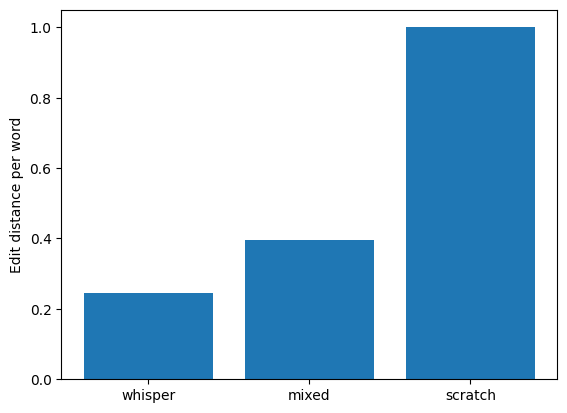

In [78]:
os.makedirs('alignments/rq1.1', exist_ok=True)

annot2texts = {k: concat_texts_by_speaker(v) for k, v in before_review_annotations.items()}

annot2edit_distances = {}
annot2numwords = {}
edit_distances = {}
totals = {}

for annot_name, (speakers, texts) in annot2texts.items():
    for t in PREFERENCE_ORDER:
        if t in annot_name:
            break
    src_speakers, src_texts = concat_texts_by_speaker(auto_annotations[annot_name])
    if 'scratch' in annot_name:
        src_texts = ['' for _ in src_texts]
        
    for speaker, text in texts.items():
        l = len(normalize_text(text))
        if speaker in src_speakers:
            agree, disagree, alignment = align_texts(text, src_texts[speaker] if speaker in src_speakers else '')
            if disagree / l > 0.9:
                print(f"{annot_name} {speaker} {t} {agree} {disagree}")
            with open(f'alignments/rq1.1/{annot_name}_{speaker}.txt', 'w') as f:
                f.write(format_alignment(*alignment))
        else:
            agree, disagree = 0, l
        edit_distances[t] = edit_distances.get(t, 0) + disagree
        totals[t] = totals.get(t, 0) + l
        annot2edit_distances[annot_name] = annot2edit_distances.get(annot_name, 0) + disagree
        annot2numwords[annot_name] = annot2numwords.get(annot_name, 0) + l


print('Edit distances:', edit_distances)
print('Total words:   ', totals)
print('Edits per word:', [(k, v / totals[k]) for k, v in edit_distances.items()])

columns = ['whisper', 'mixed', 'scratch']
values = [totals[c] for c in columns]
relativ = [edit_distances[c] / totals[c] for c in columns]
fig, ax = plt.subplots()
ax.bar(columns, relativ)
ax.set_ylabel('Edit distance per word')


A2ML_221205_15-ZM-from_mixed.xml exam_1 mixed 45 1127
Edit distances:      {'mixed': 25511, 'whisper': 8872, 'scratch': 17024}
Total characters:    {'mixed': 87589, 'whisper': 50531, 'scratch': 17024}
Edits per character: [('mixed', 0.29125803468472067), ('whisper', 0.1755753893649443), ('scratch', 1.0)]


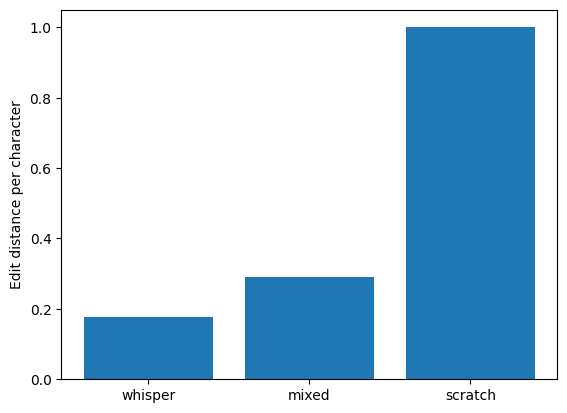

In [79]:
IS_CHAR_LEVEL = True
os.makedirs('alignments/rq1.1chars', exist_ok=True)

annot2texts = {k: concat_texts_by_speaker(v) for k, v in before_review_annotations.items()}

edit_distances = {}
totals = {}

for annot_name, (speakers, texts) in annot2texts.items():
    for t in PREFERENCE_ORDER:
        if t in annot_name:
            break
    src_speakers, src_texts = concat_texts_by_speaker(auto_annotations[annot_name])
    if 'scratch' in annot_name:
        src_texts = ['' for _ in src_texts]
        
    for speaker, text in texts.items():
        l = len(normalize_text(text))
        if speaker in src_speakers:
            agree, disagree, alignment = align_texts(text, src_texts[speaker] if speaker in src_speakers else '')
            if disagree / l > 0.9:
                print(f"{annot_name} {speaker} {t} {agree} {disagree}")
            with open(f'alignments/rq1.1chars/{annot_name}_{speaker}.txt', 'w') as f:
                f.write(format_alignment(*alignment))
        else:
            agree, disagree = 0, l
        edit_distances[t] = edit_distances.get(t, 0) + disagree
        totals[t] = totals.get(t, 0) + l


print('Edit distances:     ', edit_distances)
print('Total characters:   ', totals)
print('Edits per character:', [(k, v / totals[k]) for k, v in edit_distances.items()])

columns = ['whisper', 'mixed', 'scratch']
values = [totals[c] for c in columns]
relativ = [edit_distances[c] / totals[c] for c in columns]
fig, ax = plt.subplots()
ax.bar(columns, relativ)
ax.set_ylabel('Edit distance per character')
IS_CHAR_LEVEL = False


## Comparison over all recordings. Duration per word, per second (of the recording). Average edit distance (in words, chars).

In [80]:
os.makedirs('alignments/rq1.2', exist_ok=True)

annot2texts = {k: concat_texts_by_speaker(v) for k, v in before_review_annotations.items()}

durations = {}
annotdurations = {}
edits = {}
words = {}

for annot_name, (speakers, texts) in annot2texts.items():
    for t in PREFERENCE_ORDER:
        if t in annot_name:
            break
    if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
        durations[t] = durations.get(t, 0) + annotation2duration[annot_name]
        annotdurations[t] = annotdurations.get(t, 0) + annotation2annot_duration[annot_name]
        edits[t] = edits.get(t, 0) + annot2edit_distances[annot_name]
        words[t] = words.get(t, 0) + annot2numwords[annot_name]


print('Total times: ', durations)
print('Edit distances:', edits)
print('Annot to recording ratio:', [(k, annotdurations[k] / v) for k, v in durations.items()])
print('Annot time per word:', [(k, annotdurations[k] / v) for k, v in words.items()])
print('Annot duration per edit:', [(k, annotdurations[k] / v) for k, v in edits.items()])
print('Edit distance per word:', [(k, v / words[k]) for k, v in edits.items()])

Total times:  {'mixed': 9263.078000000001, 'whisper': 3251.0439999999994, 'scratch': 557.348}
Edit distances: {'mixed': 5205, 'whisper': 1209, 'scratch': 988}
Annot to recording ratio: [('mixed', 13.051817117377182), ('whisper', 11.14718841086125), ('scratch', 9.581087579035001)]
Annot time per word: [('mixed', 10.104471374843293), ('whisper', 7.808661926308985), ('scratch', 5.4048582995951415)]
Annot duration per edit: [('mixed', 23.227665706051873), ('whisper', 29.975186104218363), ('scratch', 5.4048582995951415)]
Edit distance per word: [('mixed', 0.4350188048474718), ('whisper', 0.2605042016806723), ('scratch', 1.0)]


### Comparison over the recordings that were both manually transcribed and manually post-edited. Total duration. Total edit distance.

In [81]:
relevant_recordings = [k for k, v in before_review_recordings.items() if any(['scratch' in a for a in v.keys()]) and len(v) > 1]

total_words = {}
total_duration = {}
total_edits = {}
total_annot_duration = {}

for recording in relevant_recordings:
    for annot_name in auto_recordings[recording]:
        for t in PREFERENCE_ORDER:
            if t in annot_name:
                break
        if t not in annot_name:
            continue
        if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
            total_words[t] = total_words.get(t, 0) + annot2numwords[annot_name]
            total_duration[t] = total_duration.get(t, 0) + annotation2duration[annot_name]
            total_edits[t] = total_edits.get(t, 0) + annot2edit_distances[annot_name]
            total_annot_duration[t] = total_annot_duration.get(t, 0) + annotation2annot_duration[annot_name]

print('Relevant recordings:', len(relevant_recordings))
print('Total words: ', total_words)
print('Total duration:', total_duration)
print('Total edits:', total_edits)
print('Total annot duration:', total_annot_duration)
print('Edits per word:', [(k, total_edits[k] / v) for k, v in total_words.items()])
print('Duration per edit:', [(k, v / total_edits[k]) for k, v in total_duration.items()])
print('Annot duration per edit:', [(k, v / total_edits[k]) for k, v in total_annot_duration.items()])

Relevant recordings: 4
Total words:  {'scratch': 988, 'mixed': 519, 'whisper': 543}
Total duration: {'scratch': 557.348, 'mixed': 293.717, 'whisper': 316.3329999999999}
Total edits: {'scratch': 988, 'mixed': 176, 'whisper': 148}
Total annot duration: {'scratch': 5340, 'mixed': 4020, 'whisper': 4740}
Edits per word: [('scratch', 1.0), ('mixed', 0.33911368015414256), ('whisper', 0.27255985267034993)]
Duration per edit: [('scratch', 0.5641174089068826), ('mixed', 1.6688465909090908), ('whisper', 2.1373851351351347)]
Annot duration per edit: [('scratch', 5.4048582995951415), ('mixed', 22.84090909090909), ('whisper', 32.027027027027025)]


### Do the duration and edit distance correlate?
TODO

### Is there a significant difference across annotators? Some might prefer one way of transcribing over the other.


In [96]:
annot2numwords.keys()

dict_keys(['A2ML_230911_39-ZM-from_mixed.xml', 'A2ML_230911_38-ET-from_mixed.xml', 'A2ML_221205_13-ZM-from_whisperX.xml', '04-npi-test-B1-MH_from_mixed.xml', 'A2ML_230911_42-AP-from_whisperX.xml', 'A2ML_221205_11-AP-from_whisperX.xml', 'A2ML_221205_11-ET-from_scratch.xml', 'A2ML_230724_23-ET-from_whisperX.xml', 'A2ML_230724_23-KV-from_mixed.xml', 'A2ML_221205_12-KV-from_whisperX.xml', 'A2ML_230724_24-ZM-from_mixed.xml', 'A2ML_221205_06-LR-from_mixed.xml', '07-npi-test-B1-KR_from_scratch.xml', '07-npi-test-B1-MH_from_whisperX.xml', 'A2ML_230724_30-AP-from_mixed.xml', 'A2ML_221205_18-KV-from_mixed.xml', 'A2ML_221205_18-ZM-from_scratch.xml', 'A2ML_221205_18-ET-from_whisperX.xml', 'A2ML_230911_33-ZM-from_mixed.xml', 'A2ML_230724_29-ET-from_mixed.xml', 'A2ML_230724_29-ZM-from_whisperX.xml', 'A2ML_230724_28-KV-from_mixed.xml', '01-npi-test-A1-MH_from_mixed.xml', 'A2ML_230724_25-KV-from_mixed.xml', 'A2ML_220919_02-ZM-from_mixed.xml', 'A2ML_220919_02-KV-from_whisperX.xml', 'A2ML_221205_01-ET-f

In [82]:
def parse_annotator(annot_name):
    n = annot_name.split('from')[0]
    n = n[:-1].split('-')[-1]
    assert len(n) > 0   
    return n

total_words = {}
total_duration = {}
total_edits = {}
total_annot_duration = {}

annotators = set([parse_annotator(a) for a in auto_annotations.keys()])



for recording in manual_recordings.keys():
    for annot_name in manual_recordings[recording]:
        for t in PREFERENCE_ORDER:
            if t in annot_name:
                break
        if t not in annot_name:
            continue

        if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
            annotator = parse_annotator(annot_name)
            total_words[f'{t}_{annotator}'] = total_words.get(f'{t}_{annotator}', 0) + annot2numwords[annot_name]
            total_duration[f'{t}_{annotator}'] = total_duration.get(f'{t}_{annotator}', 0) + annotation2duration[annot_name]
            total_edits[f'{t}_{annotator}'] = total_edits.get(f'{t}_{annotator}', 0) + annot2edit_distances[annot_name]
            total_annot_duration[f'{t}_{annotator}'] = total_annot_duration.get(f'{t}_{annotator}', 0) + annotation2annot_duration[annot_name]

print('Annotators:', annotators)
# print('Total words: ', total_words)
# print('Total duration:', total_duration)
# print('Total edits:', total_edits)
# print('Total annot duration:', total_annot_duration)
print('Edits per word:', sorted([(k, total_edits[k] / v) for k, v in total_words.items()], key=lambda x: x[0]))
print()
print('Annot duration per word:', sorted([(k, total_annot_duration[k] / v) for k, v in total_words.items()], key=lambda x: x[0]))
print()
# print('Duration per edit:', [(k, v / total_edits[k]) for k, v in total_duration.items()])
print('Annot duration per edit:', sorted([(k, v / total_edits[k]) for k, v in total_annot_duration.items()], key=lambda x: x[0]))


Annotators: {'MH', 'AP', 'LR', 'MR', 'KV', 'ZM', 'ET', 'KR'}
Edits per word: [('mixed_AP', 0.39181916038751347), ('mixed_ET', 0.4365107281041154), ('mixed_KV', 0.34239857333927776), ('mixed_LR', 0.3945225758697261), ('mixed_ZM', 0.545227698066126), ('scratch_ET', 1.0), ('scratch_ZM', 1.0), ('whisper_AP', 0.22156398104265404), ('whisper_ET', 0.2760416666666667), ('whisper_KV', 0.26006191950464397), ('whisper_ZM', 0.2678018575851393)]

Annot duration per word: [('mixed_AP', 13.659849300322929), ('mixed_ET', 11.227576503693282), ('mixed_KV', 7.73071778867588), ('mixed_LR', 11.946706143597336), ('mixed_ZM', 8.440424204616344), ('scratch_ET', 6.7114093959731544), ('scratch_ZM', 4.32532347504621), ('whisper_AP', 11.872037914691942), ('whisper_ET', 7.734375), ('whisper_KV', 6.006191950464396), ('whisper_ZM', 6.594427244582043)]

Annot duration per edit: [('mixed_AP', 34.862637362637365), ('mixed_ET', 25.72119258662369), ('mixed_KV', 22.578125), ('mixed_LR', 30.28142589118199), ('mixed_ZM', 15

Text(0.5, 1.0, 'Annotator duration per word')

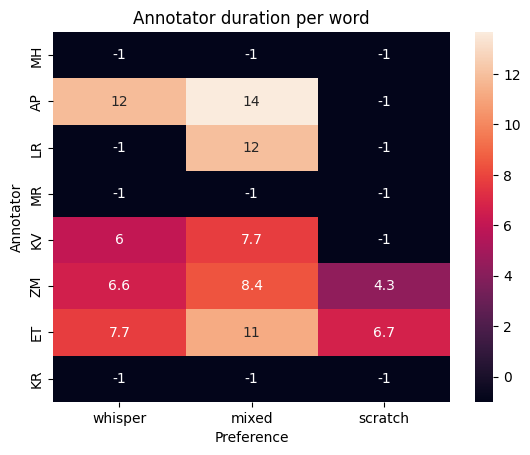

In [83]:

columns = ['whisper', 'mixed', 'scratch']
rows = list(annotators)
values = {k: total_annot_duration[k] / v for k, v in total_words.items()}
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[values.get(f'{c}_{r}', -1) for c in columns] for r in rows], annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Preference')
ax.set_ylabel('Annotator')
ax.set_title('Annotaton duration per word')


Text(0.5, 1.0, 'Annotator duration per recording duration')

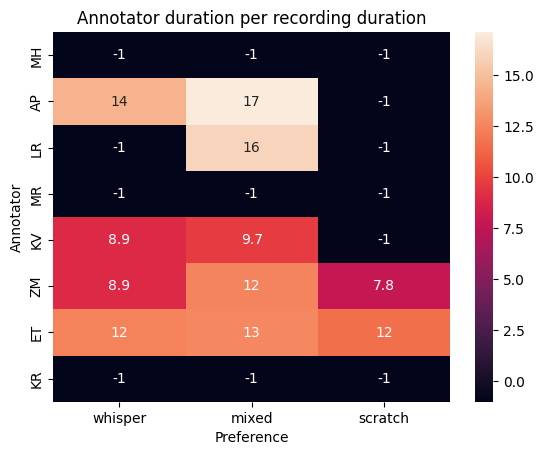

In [84]:
columns = ['whisper', 'mixed', 'scratch']
rows = list(annotators)
values = {k: total_annot_duration[k] / v for k, v in total_duration.items()}
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[values.get(f'{c}_{r}', -1) for c in columns] for r in rows], annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Preference')
ax.set_ylabel('Annotator')
ax.set_title('Annotator duration per recording duration')

### Is there a significant difference across CEFR levels?


In [ ]:
# TODO: same as above, but change the parsing of annotator name to level name


### Is there a significant difference across exercise types?

In [ ]:
# TODO

## Align AUTO to MANUAL on utterance level

Idea: concat per speaker texts -> align AUTO to MANUAL -> resegment MANUAL based on the alignment and AUTO segmentation

In [143]:
def concat_texts_by_speaker_with_source(utterances):
    speakers = set([u['speaker'] for u in utterances])
    texts = {}
    for speaker in speakers:
        words = []
        for u in utterances:
            if u['speaker'] == speaker:
                words.extend([
                    (w, u['source']) for w in normalize_text(u['text'])
                ])
        texts[speaker] = words
    return texts

relevant_annotation_names = [k for k, v in before_review_annotations.items() if 'mixed' in k]
for annot_name in relevant_annotation_names[2:]:
    before_review_texts = concat_texts_by_speaker_with_source(before_review_annotations[annot_name])
    auto_texts = concat_texts_by_speaker_with_source(auto_annotations[annot_name])

    for speaker in auto_texts.keys():
        before_review_text = before_review_texts[speaker]
        auto_text = auto_texts[speaker]
        singletons = pairwise2.align.globalcs(auto_text, before_review_text, one_alignment_only=True, gap_char=[(None, None)], open=0, extend=0,
                                                  match_fn=lambda a, b: 1 if a[0] == b[0] else 0)
        print(f"Alignment for {annot_name} {speaker} with score {singletons[0][2]}")
        curr_auto_text, curr_br_text, curr_source = [], [], None
        for (auto_text, src), (br_text, _) in zip(singletons[0][0], singletons[0][1]):
            if curr_source == None:
                curr_source = src

            if src != None and curr_source != src:
                print(f"Current source: {curr_source}")
                print(f"Auto: {' '.join(curr_auto_text)}")
                print(f"BR:   {' '.join(curr_br_text)}")
                print()
                curr_auto_text, curr_br_text, curr_source = [], [], src

            curr_auto_text += [auto_text] if auto_text != None else ''
            curr_br_text += [br_text] if br_text != None else ''
        break

            

Alignment for A2ML_221205_02-AP-from_mixed.xml cand_1 with score 50.0
Current source: whisper-large-v3
Auto: dobrý den potřebuji jeden chleb a deset rohlíků můžete ještě dát koment
Br:   ano dobrý den potřebuju jeden chléb a deset rohlíků a můžete ještě dát

Current source: whisperX-large-v2
Auto: sebo
Br:   

Current source: mms-1b-fl102
Auto: ci mate
Br:   kofe s sebou chci latté a ještě chtěla bych zepta chtěla bych zeptat

Current source: mms-1b-all
Auto: kolik ten
Br:   kolik

Current source: whisper-large-v3
Auto: na noci koladový
Br:   

Current source: mms-1b-all
Auto: stojí
Br:   stojí ten dort ano čokoládový dobře a

Current source: whisperX-large-v2
Auto: potřebuji ještě
Br:   potřebuji ještě ho

Current source: whisper-large-v3
Auto: můžu platit kartou prosím
Br:   můžu platit kartou prosím jo

Current source: mms-1b-fl102
Auto: ano tam
Br:   ano a ano

Current source: whisper-large-v3
Auto: můžeme jít do restaurace
Br:   můžeme jít do restaurace

Current source: mms-1b-fl1

## Notes
 - Using WhisperX segmentation biases the number of utterances (e.g., 07-npi-test-B1.mp3 with 161 and 273)

## Basic Stats

In [40]:
# TODO: how to compute the total duration?
total_duration = sum(list(recording.values())[0][-1]['end'] - list(recording.values())[0][0]['start'] for recording in recordings.values())
print(f"Total recordings:  {len(recordings)}")
print(f"Total duration:    {total_duration:.02f} seconds ({total_duration/60:.02f} minutes)")

# TODO: should we take the max or select some specific version?
total_utterances = sum(max(len(utterances) for utterances in transcripts.values()) for transcripts in recordings.values())
print(f"Total utterances:  {total_utterances}")

total_words = sum(
    max(
        sum(
            len(utterance['text'].split())
            for utterance in transcript
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total words:       {total_words}")


num_versions_histogram = {}
for recording, transcripts in recordings.items():
    num_versions = len(transcripts)
    num_versions_histogram[num_versions] = num_versions_histogram.get(num_versions, 0) + 1
print(f"Version histogram: {num_versions_histogram}")

num_speakers_histogram = {}
for recording, transcripts in recordings.items():
    num_speakers = max(len(set([u['speaker'] for u in utterances])) for utterances in transcripts.values())
    num_speakers_histogram[num_speakers] = num_speakers_histogram.get(num_speakers, 0) + 1
print(f"Speaker histogram: {num_speakers_histogram}")


Total recordings:  34
Total duration:    14905.59 seconds (248.43 minutes)
Total utterances:  3531
Total words:       20799
Version histogram: {1: 28, 2: 5, 3: 1}
Speaker histogram: {2: 29, 3: 5}


## Students Stats

In [33]:
total_student_duration = sum(
    max(
        sum(
            utterance['end'] - utterance['start']
            for utterance in transcript
            if utterance['speaker'] != 't'
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student duration:    {total_student_duration:.02f} seconds ({total_student_duration/60:.02f} minutes); {total_student_duration/total_duration*100:.02f}% of total duration")

total_student_utterances = sum(
    max(
        sum(
            utterance['speaker'] != 't'
            for utterance in transcript
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student utterances:  {total_student_utterances} ({total_student_utterances/total_utterances*100:.02f}% of total utterances)")

total_student_words = sum(
    max(
        sum(
            len(utterance['text'].split())
            for utterance in transcript
            if utterance['speaker'] != 't'
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student words:       {total_student_words} ({total_student_words/total_words*100:.02f}% of total words)")

Total student duration:    6923.39 seconds (115.39 minutes); 46.42% of total duration
Total student utterances:  1650 (46.73% of total utterances)
Total student words:       9546 (45.90% of total words)


## Level Stats

In [41]:
for level in ['A1', 'A2', 'B1', 'B2', 'C1']:
    relevant = [transcript_version_select(r) for n, r in recordings.items() if level in n]
    
    duration = sum(transcript[-1]['end'] - transcript[0]['start'] for transcript in relevant)
    print(f'{level}: {len(relevant)} recordings; {duration:.02f} seconds ({duration/60:.02f} minutes)')

    

A1: 1 recordings; 192.32 seconds (3.21 minutes)
A2: 30 recordings; 11441.69 seconds (190.69 minutes)
B1: 2 recordings; 2378.57 seconds (39.64 minutes)
B2: 1 recordings; 897.39 seconds (14.96 minutes)
C1: 0 recordings; 0.00 seconds (0.00 minutes)


## Inter-annotator Agreement

Recording A2ML_221205_11_anonym_audio.mp3
  A2ML_221205_11-AP-from_whisperX.xml vs A2ML_221205_11-ET-from_scratch.xml (student cand_1):	 67.56% agreement	 327 agree, 157 disagree
  A2ML_221205_11-AP-from_whisperX.xml vs A2ML_221205_11-ET-from_scratch.xml (student exam_1):	 90.52% agreement	 974 agree, 102 disagree
Recording A2ML_230724_23_anonym_audio.mp3
  A2ML_230724_23-ET-from_whisperX.xml vs A2ML_230724_23-KV-from_mixed.xml (student cand_1):	 93.31% agreement	 683 agree, 49 disagree
  A2ML_230724_23-ET-from_whisperX.xml vs A2ML_230724_23-KV-from_mixed.xml (student exam_1):	 94.59% agreement	 926 agree, 53 disagree
Recording 07-npi-test-B1.mp3
Recording A2ML_221205_18_anonym_audio.mp3
  A2ML_221205_18-KV-from_mixed.xml vs A2ML_221205_18-ZM-from_scratch.xml (student cand_1):	 79.92% agreement	 585 agree, 147 disagree
  A2ML_221205_18-KV-from_mixed.xml vs A2ML_221205_18-ZM-from_scratch.xml (student exam_1):	 92.06% agreement	 1101 agree, 95 disagree
  A2ML_221205_18-KV-from_mixed.xml 

Text(50.722222222222214, 0.5, 'Hypothesis')

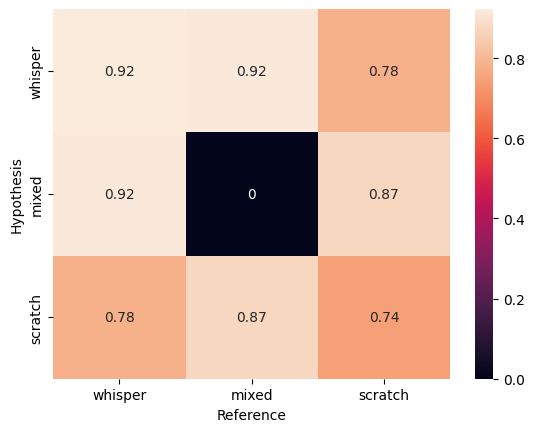

In [142]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from mosestokenizer import MosesTokenizer, MosesPunctuationNormalizer

if not os.path.exists('alignments'):
    os.makedirs('alignments')

punct_normalizer = MosesPunctuationNormalizer('cs')
tokenizer = MosesTokenizer('cs')

def normalize_text(text):
    text = text.lower().replace('\n', " ")
    text = punct_normalizer(text)
    text = tokenizer(text)
    return [t for t in text if t.isalnum()]

def align_texts_w(text1, text2):
    text1 = normalize_text(text1)
    text2 = normalize_text(text2)
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, gap_char=['-'], open=-1, extend=-1)
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def align_texts(text1, text2):
    text1 = list("".join(normalize_text(text1)))
    text2 = list("".join(normalize_text(text2)))
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, open=-1, extend=-1, gap_char=['-'])
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def concat_texts_by_speaker(utterances):
    speakers = set([u['speaker'] for u in utterances])
    texts = {}
    for speaker in speakers:
        texts[speaker] = ' '.join([u['text'] for u in utterances if u['speaker'] == speaker])
    return speakers, texts

relevant = {n: r for n, r in manual_recordings.items() if len(r) > 1}

def get_type(name):
    if 'whisper' in name:
        return 'whisper'
    if 'mixed' in name:
        return 'mixed'
    if 'scratch' in name:
        return 'scratch'
    return 'unknown'

agreements = {}
disagreements = {}

for name, transcripts in relevant.items():
    print(f"Recording {name}")
    for idx, (n1, t1) in enumerate(list(transcripts.items())):
        speakers, t1 = concat_texts_by_speaker(t1)
        for n2, t2 in list(transcripts.items())[idx+1:]:
            speakers, t2 = concat_texts_by_speaker(t2)
            for speaker in speakers:
                agree, disagree, alignment = align_texts(t1[speaker], t2[speaker])
                if agree / (agree + disagree) < 0.25:
                    continue
                speaker = 'teacher' if speaker == 't' else 'student ' + speaker
                print(f"  {n1} vs {n2} ({speaker}):\t {agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree")
                agreements[get_type(n1), get_type(n2)] = agreements.get((get_type(n1), get_type(n2)), 0) + agree
                disagreements[get_type(n1), get_type(n2)] = disagreements.get((get_type(n1), get_type(n2)), 0) + disagree
                
                agreements[get_type(n2), get_type(n1)] = agreements[get_type(n1), get_type(n2)]
                disagreements[get_type(n2), get_type(n1)] = disagreements[get_type(n1), get_type(n2)]

                with open(f'alignments/{name}_{n1}_{n2}_{speaker}.txt', 'w') as f:
                    f.write(format_alignment(*alignment))
                    f.write(f"\n{agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree\n")



print(agreements)
print(disagreements)
print({k: v / (disagreements[k] + v) for k, v in agreements.items()})

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[agreements.get((r, c), 0) / (disagreements.get((r, c), 0) + agreements.get((r, c), 1)) for c in ['whisper', 'mixed', 'scratch']] for r in ['whisper', 'mixed', 'scratch']], annot=True, ax=ax, xticklabels=['whisper', 'mixed', 'scratch'], yticklabels=['whisper', 'mixed', 'scratch'])
ax.set_xlabel('Reference')
ax.set_ylabel('Hypothesis')
